# AI - CA3 - Machine Learning
## Ali Borzoozadeh - 810102410

### Data preprocessing and feature engineering

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
from collections import Counter

#### Column deletion

We will remove columns with:
- Too many missing values.
- Irrelevant information (e.g., IDs, duplicate columns, or columns with the same value for all rows).

In [2]:
df = pd.read_csv('Grades.csv')
missing = df.isnull().sum()
print("Missing values per column:\n", missing)

Missing values per column:
 university           0
sex                  0
age                  0
address              0
motherEducation      0
fatherEducation      0
motherJob            0
fatherJob            0
reason               0
travelTime           0
studyTime            0
failures             0
universitySupport    0
paid                 0
higher               0
internet             0
romantic             0
freeTime             0
goOut                0
Dalc                 0
Walc                 0
absences             0
EPSGrade             0
DSGrade              0
finalGrade           0
dtype: int64


As we can see, we don't have missing values ​​in any of the columns and we don't have any columns with irrelevant information. So there's no need to delete any columns.

#### Filling missing data
##### Numerical columns:
- Mean Imputation: Replacing missing values with the mean.
- Median Imputation: Replacing missing values with the median.
- KNN Imputation: Using KNN to estimate missing values.

##### Categorical columns:
- Mode Imputation: Replacing missing values with the most frequent value.
- Constant Imputation: Replacing missing values with a constant (e.g., 'Unknown').
- KNN Imputation: Using KNN for categorical data as well.

Again, as we can see, we have no missing values ​​and there is no need to make any changes in this section.

#### Extract Numeric Data from Text Columns
Since the numeric data is only in the form of numbers in the dataset, there is no need to do this.

#### Convert Categorical Data to Numeric
- Using Label Encoding for ordinal data.
- Using One-Hot Encoding for nominal data.

We will use Label Encoding.

In [3]:
cat_cols = df.select_dtypes(include=['object']).columns
df_updated = df.copy()

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_updated[col] = le.fit_transform(df_updated[col].astype(str))
    label_encoders[col] = le

print("Categorical columns after encoding:\n", df_updated[cat_cols])

Categorical columns after encoding:
      university  sex  address  motherJob  fatherJob  reason  \
0             1    0        1          0          4       0   
1             1    0        1          0          2       0   
2             1    0        1          0          2       2   
3             1    0        1          1          3       1   
4             1    0        1          2          2       1   
..          ...  ...      ...        ...        ...     ...   
392           0    1        0          2          2       0   
393           0    1        0          3          2       0   
394           0    1        1          2          0       0   
395           1    0        1          0          4       0   
396           0    1        0          2          3       2   

     universitySupport  paid  higher  internet  romantic  
0                    1     0       1         0         0  
1                    0     0       1         1         0  
2                    1     1 

#### Create classes for grades
- A: Above 17
- B: Between 14 and 17
- C: Between 10 and 14
- D: Under 10

In [4]:
def grade_to_class(grade):
    if grade > 17:
        return 'A'
    elif grade >= 14:
        return 'B'
    elif grade >= 10:
        return 'C'
    else:
        return 'D'

df_updated['finalGradeClass'] = df_updated['finalGrade'].apply(grade_to_class)
print(df_updated[['finalGrade', 'finalGradeClass']].head())

   finalGrade finalGradeClass
0           6               D
1           6               D
2          10               C
3          15               B
4          10               C


### Development, training and evaluation of models

#### Train-Test split

In [5]:
X = df_updated.drop(['finalGrade', 'finalGradeClass'], axis=1)
y = df_updated['finalGradeClass']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())

Train shape: (317, 24)
Test shape: (80, 24)
Train class distribution:
 finalGradeClass
C    132
D    105
B     66
A     14
Name: count, dtype: int64
Test class distribution:
 finalGradeClass
C    33
D    27
B    16
A     4
Name: count, dtype: int64


#### Normalization / Standardization

`StandardScaler()` from scikit-learn standardizes features by removing the mean and scaling to unit variance.

```z = (x - mean) / std```

In [6]:
num_cols = X_train.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

#### Sklearn Models

##### Naive Bayes

In [7]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Naive Bayes Accuracy: 0.575

Classification Report:
               precision    recall  f1-score   support

           A       0.23      0.75      0.35         4
           B       0.27      0.38      0.32        16
           C       0.87      0.39      0.54        33
           D       0.80      0.89      0.84        27

    accuracy                           0.57        80
   macro avg       0.54      0.60      0.51        80
weighted avg       0.69      0.57      0.59        80


Confusion Matrix:
 [[ 3  1  0  0]
 [10  6  0  0]
 [ 0 14 13  6]
 [ 0  1  2 24]]


##### Decision Tree

Decision Tree Accuracy: 0.8875

Classification Report:
               precision    recall  f1-score   support

           A       0.80      1.00      0.89         4
           B       0.93      0.88      0.90        16
           C       0.86      0.91      0.88        33
           D       0.92      0.85      0.88        27

    accuracy                           0.89        80
   macro avg       0.88      0.91      0.89        80
weighted avg       0.89      0.89      0.89        80


Confusion Matrix:
 [[ 4  0  0  0]
 [ 1 14  1  0]
 [ 0  1 30  2]
 [ 0  0  4 23]]


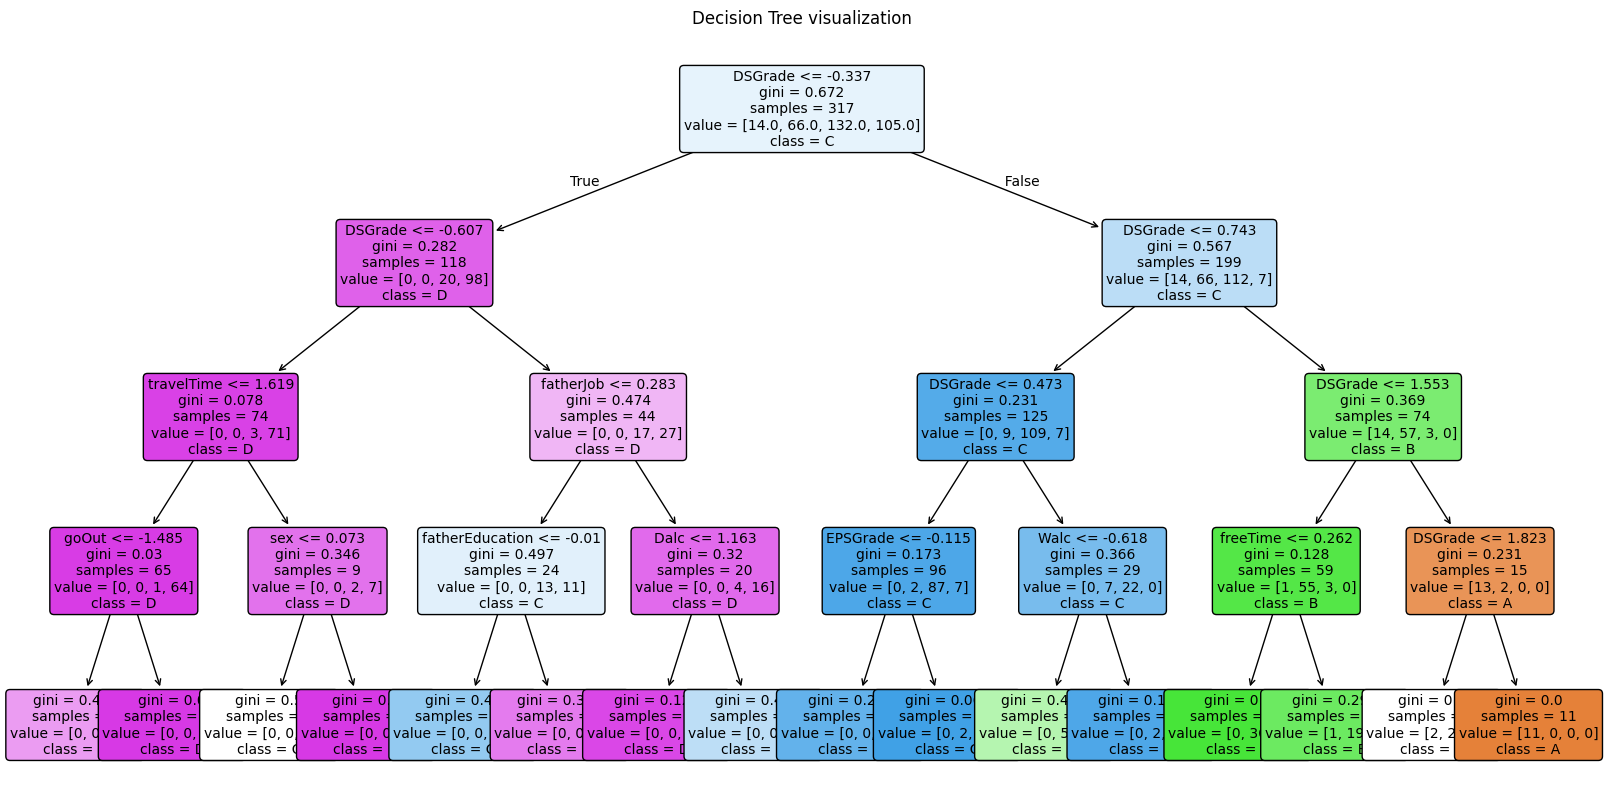


Feature importances:
              feature  importance
23            DSGrade    0.912784
20               Walc    0.019854
7           fatherJob    0.015552
19               Dalc    0.013026
5     fatherEducation    0.012466
22           EPSGrade    0.007309
1                 sex    0.006784
17           freeTime    0.004212
9          travelTime    0.004130
18              goOut    0.003883
14             higher    0.000000
21           absences    0.000000
16           romantic    0.000000
15           internet    0.000000
0          university    0.000000
13               paid    0.000000
11           failures    0.000000
10          studyTime    0.000000
8              reason    0.000000
6           motherJob    0.000000
4     motherEducation    0.000000
3             address    0.000000
2                 age    0.000000
12  universitySupport    0.000000


In [8]:
dt_model = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=3,
    random_state=42
)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

plt.figure(figsize=(20,10))
plot_tree(
    dt_model, 
    feature_names=X_train.columns, 
    class_names=dt_model.classes_, 
    filled=True, 
    rounded=True, 
    fontsize=10
)
plt.title("Decision Tree visualization")
plt.show()

importances = dt_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature importances:")
print(feature_importance_df)

As we can see, DSGrade is the most important feature and has a huge impact by far.

##### Random Forest

In [9]:
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 4, 6, 8, 10],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)

rf_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=20, cv=3, scoring='accuracy', random_state=42, n_jobs=-1
)
rf_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_

y_pred_rf = best_rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nBest Hyperparameters:", rf_search.best_params_)

rf_importances = best_rf.feature_importances_
rf_feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_importances
}).sort_values(by='importance', ascending=False)

print("\nFeature importances:")
print(rf_feature_importance_df)

Random Forest Accuracy: 0.8625

Classification Report:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00         4
           B       0.87      0.81      0.84        16
           C       0.84      0.82      0.83        33
           D       0.86      0.93      0.89        27

    accuracy                           0.86        80
   macro avg       0.89      0.89      0.89        80
weighted avg       0.86      0.86      0.86        80


Confusion Matrix:
 [[ 4  0  0  0]
 [ 0 13  3  0]
 [ 0  2 27  4]
 [ 0  0  2 25]]

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10}

Feature importances:
              feature  importance
23            DSGrade    0.338656
22           EPSGrade    0.191099
21           absences    0.050771
20               Walc    0.035382
4     motherEducation    0.032891
2                 age    0.030135
11           failures    0.029782
1

As we can see, DSGrade is still the most important feature, but this time its difference from other features is less.

##### XGBoost

In [10]:
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 6, 8],
    'min_child_weight': [1, 2, 3],  # min_child_weight instead of min_samples_leaf
    'min_split_loss': [0, 1, 2],    # min_split_loss instead of min_samples_split
    'max_leaves': [0, 5, 10],
    'colsample_bytree': [0.8, 1.0], # colsample_bytree instead of max_features
}

le_y = LabelEncoder()
y_train_xgb = le_y.fit_transform(y_train)
y_test_xgb = le_y.transform(y_test)

xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le_y.classes_),
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

xgb_search = GridSearchCV(
    xgb, param_grid=param_grid,
    cv=3, scoring='accuracy', n_jobs=-1
)
xgb_search.fit(X_train, y_train_xgb)

best_xgb = xgb_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

y_pred_xgb_labels = le_y.inverse_transform(y_pred_xgb)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb_labels))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb_labels))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb_labels))
print("\nBest Hyperparameters:", xgb_search.best_params_)

XGBoost Accuracy: 0.8875

Classification Report:
               precision    recall  f1-score   support

           A       0.80      1.00      0.89         4
           B       1.00      0.75      0.86        16
           C       0.86      0.91      0.88        33
           D       0.89      0.93      0.91        27

    accuracy                           0.89        80
   macro avg       0.89      0.90      0.88        80
weighted avg       0.89      0.89      0.89        80


Confusion Matrix:
 [[ 4  0  0  0]
 [ 1 12  3  0]
 [ 0  0 30  3]
 [ 0  0  2 25]]

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'max_leaves': 0, 'min_child_weight': 2, 'min_split_loss': 1, 'n_estimators': 100}


##### Decision Tree from Scratch

In [11]:
class DecisionTreeScratch:
    def __init__(self, max_depth=4, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def _entropy(self, y):
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

    def _best_split(self, X, y):
        best_gain = 0
        best_feature = None
        best_threshold = None
        n_features = X.shape[1]
        current_entropy = self._entropy(y)
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = X[:, feature] > threshold
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                left_entropy = self._entropy(y[left_mask])
                right_entropy = self._entropy(y[right_mask])
                n = len(y)
                n_left = np.sum(left_mask)
                n_right = np.sum(right_mask)
                weighted_entropy = (n_left / n) * left_entropy + (n_right / n) * right_entropy
                info_gain = current_entropy - weighted_entropy
                if info_gain > best_gain:
                    best_gain = info_gain
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold

    def _build_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        if (depth >= self.max_depth or num_labels == 1 or num_samples < self.min_samples_split):
            leaf_value = Counter(y).most_common(1)[0][0]
            return {'type': 'leaf', 'class': leaf_value}

        feature, threshold = self._best_split(X, y)
        if feature is None:
            leaf_value = Counter(y).most_common(1)[0][0]
            return {'type': 'leaf', 'class': leaf_value}

        left_mask = X[:, feature] <= threshold
        right_mask = X[:, feature] > threshold

        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return {
            'type': 'node',
            'feature': feature,
            'threshold': threshold,
            'left': left_subtree,
            'right': right_subtree
        }

    def fit(self, X, y):
        if not np.issubdtype(y.dtype, np.integer):
            classes, y = np.unique(y, return_inverse=True)
            self.classes_ = classes
        else:
            self.classes_ = np.unique(y)
        self.tree = self._build_tree(np.array(X), np.array(y), 0)

    def _predict_one(self, x, node):
        if node['type'] == 'leaf':
            return node['class']
        if x[node['feature']] <= node['threshold']:
            return self._predict_one(x, node['left'])
        else:
            return self._predict_one(x, node['right'])

    def predict(self, X):
        X = np.array(X)
        preds = [self._predict_one(x, self.tree) for x in X]
        if hasattr(self, 'classes_') and not np.issubdtype(self.classes_.dtype, np.integer):
            preds = [self.classes_[i] for i in preds]
        return np.array(preds)

dt_scratch = DecisionTreeScratch(max_depth=4)
dt_scratch.fit(X_train, y_train)
y_pred = dt_scratch.predict(X_test)

print("DTFS Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

DTFS Accuracy: 0.8625

Classification Report:
               precision    recall  f1-score   support

           A       0.80      1.00      0.89         4
           B       1.00      0.69      0.81        16
           C       0.85      0.85      0.85        33
           D       0.84      0.96      0.90        27

    accuracy                           0.86        80
   macro avg       0.87      0.87      0.86        80
weighted avg       0.87      0.86      0.86        80


Confusion Matrix:
 [[ 4  0  0  0]
 [ 1 11  4  0]
 [ 0  0 28  5]
 [ 0  0  1 26]]


##### Decision Tree from Scratch (Library implementation)

In [12]:
sk_dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=2, random_state=42)
sk_dt.fit(X_train, y_train)
y_pred_sk = sk_dt.predict(X_test)

print("Scikit-learn Decision Tree Accuracy:", accuracy_score(y_test, y_pred_sk))
print("\nClassification Report:\n", classification_report(y_test, y_pred_sk))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_sk))

Scikit-learn Decision Tree Accuracy: 0.8875

Classification Report:
               precision    recall  f1-score   support

           A       0.80      1.00      0.89         4
           B       0.93      0.88      0.90        16
           C       0.86      0.91      0.88        33
           D       0.92      0.85      0.88        27

    accuracy                           0.89        80
   macro avg       0.88      0.91      0.89        80
weighted avg       0.89      0.89      0.89        80


Confusion Matrix:
 [[ 4  0  0  0]
 [ 1 14  1  0]
 [ 0  1 30  2]
 [ 0  0  4 23]]


As we can see, the version implemented by the library is more accurate.

We can use manual implementation to learn and demonstrate the algorithm, and use scikit-learn for real data analysis, better performance, and more features.